Load in df data from prev notebook.
* `munge_pt2_disease_hierarchy.ipynb`
*  `df_temp = pd.concat([X,y])
df_temp.to_parquet("features_data_export.parquet")`

* Do train/test split by parent ancestor group , top level
    * By 1 level down (max is 10% for one group) - ~ similar res: 82 vs 83 auc
* Do histogram of pred scores distrib

* get error by source / cat e.g. orphanet
     * Done

* check consistency +- drop duplicates by disease name
    * Model results are about same - 83 AUC

* פירוק לפי דימפטומים, תופעות לוואי, by phenotypes
* count total evidence by source (e.g. # somatic, genetic, etc) + fraction of total from them - for interpretability

---------------

* Using 0/1 instead of evidence score: no change (both get 83.2 AUC on random split)
* Including associated evidence: 93 auc (over ~83)

* Keeping vs dropping `source` col for model (when using grouped by `name`) - 83 vs 79 auc



---- 

* Add single feature model - by source
    * 55.5 AUC
* OPT: eval by source? LOO (for top groups)
* For predicted to have children - plot distribution of actual # children

In [1]:
import pandas as pd
import numpy as np
import ast 

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import f_classif, chi2,SelectFromModel,SelectKBest,mutual_info_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV, ElasticNet
from sklearn.linear_model import RidgeCV
from  sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score,GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report,average_precision_score
from sklearn.feature_selection import SelectFpr, SelectFdr
import re
from sklearn.metrics import jaccard_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import shap
from catboost import Pool, CatBoostClassifier
from scipy.stats import mode
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, RepeatedStratifiedKFold
from scipy.stats import ttest_rel, chi2, ttest_ind
from time import sleep
import matplotlib.pyplot as plt
# import seaborn as sns
shap.initjs()

import matplotlib.pyplot as plt
plt.figure(dpi=1200)
%matplotlib inline
import seaborn


from sklearn import set_config
set_config(transform_output = "pandas")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


<Figure size 7680x5760 with 0 Axes>

In [2]:
GET_PREDS = True#False

DO_SVD = True#False # keep raw inputs. MANY cols!!

DO_LEAKY_FS = True#False#True # leaky train on train feature sel..  - only used during debugging, unless just filtering by variance - not target based

DO_DL = True
SAVE_CANDIDATES = True#False # save output predicted candidates - overwrites

RUN_STABILITY_PREDS = True ## run many repeated CV preds and check stability of predicitons 
NUM_ENCODE_SOURCE = False

In [3]:
from re import sub

def prettify_feature_names(s):
    """replace _ with space and camel case and additional changes to make output feature names look nicer"""
    
    s = s.replace("_000000"," ").replace("pct","Percent").replace("dl_","Text Embedding Vector ").replace("ENSG00000","ENSG ")
    s = s.replace("Evidencecount","Evidence count").replace("byDisease","by Disease")
    s = sub(r"(_|-)+", " ", s).title()
    return ''.join(s)

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#### Export data

In [4]:
if DO_DL:
    df = pd.read_parquet("features_data_DL_export.parquet")
else: 
    df = pd.read_parquet("features_data_export.parquet")
    
df = df.convert_dtypes(convert_string=False) ## parses ~ 990 floats ot int. Note that memory usage isn't actualy lowered/;
df["has_children"] = df["has_children"].astype(int)
df

,animal_model,animal_model_ratio_to_smallest,min_phenotype_frequency,known_drug,total_source_cases,genetic_association_ratio_to_biggest,evidenceCount_byDisease_avg,All_ICD_counts,datasource_nunique,genetic_association_ratio_to_smallest,...,dl_759,dl_760,dl_761,dl_762,dl_763,dl_764,dl_765,dl_766,dl_767,has_children
name,,,,,,,,,,,,,,,,,,,,,
10p11.21p12.31 microdeletion syndrome,2,1.0,2,0,4,1.0,8.25,0,3,1.0,...,-0.052247,0.007615,0.003228,-0.043482,0.03513,0.007117,0.005671,0.035386,0.021123,0
10q22.3q23.3 microduplication syndrome,4,1.0,0,0,4,0.0,1.0,0,1,0.0,...,0.001283,0.018512,-0.004181,-0.050078,0.015843,-0.042857,-0.022079,0.036755,-0.017979,0
11p15.4 microduplication syndrome,0,0.0,0,0,0,0.0,0.0,0,0,0.0,...,-0.052197,-0.014921,-0.000551,-0.045029,-0.007862,0.017467,-0.028892,0.029537,0.026184,0
12p12.1 microdeletion syndrome,2,2.0,14,0,3,0.5,1.0,0,2,1.0,...,-0.032878,-0.001697,0.004625,-0.045002,0.041962,0.031034,0.016089,0.051643,0.036005,0
12q14 microdeletion syndrome,169,1.0,0,0,169,0.0,1.177515,0,1,0.0,...,-0.03349,-0.008628,0.001113,-0.062398,0.027995,0.015936,0.017756,0.067076,0.049477,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygodactyly type 1,0,0.0,0,0,0,0.0,0.0,0,0,0.0,...,0.034138,-0.040213,-0.009371,0.042589,-0.068829,-0.011363,-0.012568,0.027965,0.025432,0
zygodactyly type 2,0,0.0,0,0,0,0.0,0.0,0,0,0.0,...,0.033994,-0.040495,-0.015365,0.042242,-0.060812,-0.008457,-0.012942,0.023673,0.018475,0
zygodactyly type 3,0,0.0,0,0,1,1.0,1.0,0,1,1.0,...,0.036358,-0.041362,-0.006218,0.040948,-0.044446,-0.016768,-0.009939,0.017447,0.022398,0


In [5]:
%%time
if DO_LEAKY_FS:
    ## leaky FS 
    # fs = SelectFpr(score_func=chi2,alpha=0.25)
    fs = Pipeline([ #("SimpleImputer",SimpleImputer(strategy="most_frequent")), # "most_frequent"
         ("var",VarianceThreshold(0.0005)), # drops most of columns
#         ("statf",SelectFpr(score_func= f_classif,alpha=0.1)),
# #         ("statk",SelectKBest(score_func= mutual_info_classif,k=5200)) ## 2500 # slow with thousands of features!!
                  ])
    X = df.drop(columns="has_children").select_dtypes("number")
    X.columns = X.columns.astype(str)
    X.fillna(0,inplace=True)
    y = df["has_children"]
    fs.fit(X,y)
    ##LEAKY!!!: 
    print("pre filt",df.shape) # 4182
    df = df.filter(["source","has_children"]+list(fs.get_feature_names_out()),axis=1)
#     df = df.loc[:,~df.columns.duplicated()].copy() # drop a col getting duplicated in case that happens
    X = X.filter(["source"]+list(fs.get_feature_names_out()),axis=1)
    print(df.shape)  # 40281

pre filt (17222, 3394)
(17222, 3185)
CPU times: user 703 ms, sys: 442 ms, total: 1.14 s
Wall time: 1.14 s


In [6]:
# %%time ## > 5 min
# mi_scores = make_mi_scores(X, y)
# mi_scores.describe()

    count    4223.000000
    mean        0.003558
    std         0.003901
    min         0.000000
    25%         0.000087
    50%         0.002703
    75%         0.005566
    max         0.058090
    Name: MI Scores
    
    
    mi_scores[mi_scores>0.0001] # 3163
    mi_scores[mi_scores>0.001] # 2816

In [7]:
X = df.drop(columns=["has_children"],errors="ignore")
print(X.shape)
y = df["has_children"]
assert y.dropna().sum()>50
print(y.agg(["count","mean","sum"]).round(2))

assert y.shape[0]==X.shape[0]

(17222, 3184)
count    17222.00
mean         0.34
sum       5848.00
Name: has_children, dtype: float64


## Cont model

In [8]:
X.source.value_counts()

source
MONDO       8801
EFO         4590
Orphanet    2061
HP          1366
GO           352
OBA           27
OTAR           9
DOID           6
OBI            4
NCIT           3
MP             2
OGMS           1
Name: count, dtype: int64

In [9]:
# ## OPT: String / categorical feature of disease source. may be leak or bias??
# X["source"] = [i[0] for i in list(X.index.str.split("_",expand=True))]## ORIG before index change with grp#[:,0]
## warning - ordinal instead of OHE encoding
if NUM_ENCODE_SOURCE: # useful for running other models
    lbl = LabelEncoder().fit(X.source)
    cat_col = X.columns.get_loc("source")
    X.iloc[:,cat_col]
    X.iloc[:,cat_col] = lbl.transform(X.source)

### Check prediction stability via repeated runs
* +- do CV with groups? 

In [10]:
%%time
if RUN_STABILITY_PREDS:
    n_splits = 5
    n_runs = 8 #8
    # Define your model
    model = CatBoostClassifier(#iterations=600,
                               cat_features=["source"],verbose=False,
                               early_stopping_rounds=60, # metric_period=10, ## - ignored if using od
        thread_count=9,
                               auto_class_weights = "SqrtBalanced"
#                             , task_type="GPU"
    )   

    # Initialize an array to store predictions across runs/folds
    predictions = np.zeros((X.shape[0], n_runs)) 
    proba_predictions = np.zeros((X.shape[0], n_runs)) # store probabilities

    # Train and predict with the model for different CV runs and folds
    for run in range(n_runs):
        print("Run",run)
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42 + run)
        for i, (train_index, test_index) in enumerate(cv.split(X, y)):
            if i//3 == 0:print(i)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model.fit(X_train, y_train, eval_set=(X_test, y_test))
            predictions[test_index,  run] = model.predict(X_test) 
            proba_predictions[test_index,  run] = model.predict_proba(X_test)[:,1]
        print("model.get_best_iteration",model.get_best_iteration())

    # Calculate the consistency of predictions for each instance
    consistency = np.sum(predictions == y.to_numpy().reshape(-1, 1), axis=1) /  n_runs

    # Compute average consistency
    avg_consistency = np.mean(consistency)

    # Calculate Jaccard similarity
    jaccard = jaccard_score(y, np.round(mode(predictions, axis=1)[0]).astype(int)) # was np.mean alt, still not working? 

    print(f"Average Consistency: {avg_consistency:.3f}")
    print(f"Jaccard Similarity: {jaccard:.4f}")
    
    # Count the number of unique predictions per instance
    unique_predictions_per_instance = np.apply_along_axis(lambda x: len(np.unique(x)), axis=1, arr=predictions)
    # Find the instances where all predictions are identical (i.e., only one unique prediction)
    identical_predictions = np.sum(unique_predictions_per_instance == 1)

    print(f"Frac instances with identical predictions: {100*identical_predictions/predictions.shape[0]}")

Run 0
0
1
2
model.get_best_iteration 980
Run 1
0
1
2
model.get_best_iteration 826
Run 2
0
1
2
model.get_best_iteration 879
Run 3
0
1
2
model.get_best_iteration 998
Run 4
0
1
2
model.get_best_iteration 948
Run 5
0
1
2
model.get_best_iteration 874
Run 6
0
1
2
model.get_best_iteration 736
Run 7
0
1
2
model.get_best_iteration 874
Average Consistency: 0.850
Jaccard Similarity: 0.6357


Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


Frac instances with identical predictions: 85.95401230983626
CPU times: user 3h 22min 53s, sys: 3min 28s, total: 3h 26min 22s
Wall time: 29min 23s


In [11]:
print(f"Ensemble rocAUC {roc_auc_score(y, proba_predictions.mean(axis=1)):.4f}") ## 0.898
# print(f"discrete rocAUC {roc_auc_score(y, predictions.mean(axis=1)):.3f}") ## 0.853
print(f"PR-AUC {average_precision_score(y, proba_predictions.mean(axis=1)):.4f}")

Ensemble rocAUC 0.9109
PR-AUC 0.8675


In [12]:
proba_predictions.max()

0.9996807921734616

In [13]:
proba_predictions.min()

0.00039270833993248236

In [14]:
print(classification_report(y,mode(predictions, axis=1)[0].astype(int)))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89     11374
           1       0.82      0.74      0.78      5848

    accuracy                           0.86     17222
   macro avg       0.85      0.83      0.84     17222
weighted avg       0.85      0.86      0.85     17222



Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


(With SVD , without DL feats, Catboost 200 iter): 

    Average Consistency: 
    Jaccard Similarity: 0.00
    Frac instances with identical predictions: 

In [15]:
print(predictions.std(axis=1).mean())
print(set(predictions.std(axis=1).round(3)))

0.057145679739275035
{0.0, 0.484, 0.433, 0.331, 0.5}


In [16]:
pd.value_counts(predictions.std(axis=1).round(2),normalize=True).round(2)

0.00    0.86
0.33    0.06
0.43    0.04
0.48    0.03
0.50    0.02
Name: proportion, dtype: float64

### get predictions and candidate mismatches
* Get predictions
* `df_candidate_errors` - Get cases with high stability in CV predictions (`CV_stable`) (and sorted/ranked by high model confidence) , AND compare to cases where the predicted labels differs from that in the raw data

In [17]:
df["CV_stable"] = (predictions.std(axis=1)<= 0) ## arbitrary cutoff - split count depemdent - 4/5 agreement
df["CV_pred"] = mode(predictions, axis=1)[0].astype(int)

df["CV_mean"] = (proba_predictions.mean(axis=1)) # proxy for sorting, if we had probas and not just all 0/1

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


In [18]:
if SAVE_CANDIDATES:
    df.to_csv("temp_eval_df.csv.gz",index=True,compression="gzip")

In [19]:
df[["CV_pred","has_children","CV_stable"]].mean().round(3)

CV_pred         0.305
has_children    0.340
CV_stable       0.860
dtype: float64

In [20]:
long_colnames_list = [c for c in df.columns if len(c)>3] # hack to drop numeric cols like embeddings

In [21]:
df_candidate_errors = df.loc[(df["CV_pred"] != df["has_children"]) & (df["CV_stable"])]
# df=df[[i for i in df if len(set(df[i]))>1]] # drop unary cols
print(df_candidate_errors.shape[0])
df_candidate_errors = df_candidate_errors.filter(long_colnames_list,axis=1).reset_index().round(2)
df_candidate_errors=df_candidate_errors[[i for i in df_candidate_errors if len(set(df_candidate_errors[i]))>1]]# drop unary cols

df_candidate_errors.sort_values(["CV_mean"],ascending=False,inplace=True)
df_candidate_errors ### 1724 when using grpby names # 2664 rows  (2662 when using less splits and another run = very stable!)

1531


,name,value_HP_0001795,value_HP_0000453,score_ENSG00000132781,value_HP_0000883,score_ENSG00000113448,dl_479,value_HP_0000695,dl_29,value_HP_0003233,...,dl_413,score_ENSG00000166147,value_HP_0001566,dl_453,value_HP_0009473,dl_285,value_HP_0001281,value_HP_0003577,CV_pred,CV_mean
32,abnormality of glycosaminoglycan metabolism,0,0,0.0,0,0.0,-0.04,0,0.02,0,...,-0.06,0.0,0,0.08,0,0.04,0,0,1,0.98
1395,structural epilepsy,0,0,0.0,0,0.0,-0.03,0,0.03,0,...,-0.01,0.0,0,-0.02,0,0.02,0,0,1,0.98
1057,nephropathy,0,0,0.0,0,0.0,0.03,0,-0.01,0,...,-0.02,0.0,0,0.05,0,-0.09,0,0,1,0.98
560,extrapyramidal and movement disease,0,0,0.0,0,0.0,0.04,0,0.04,0,...,0.04,0.0,0,-0.13,0,-0.04,0,0,1,0.98
1344,sexual and gender identity disorders,0,0,0.0,0,0.0,0.01,0,0.08,0,...,-0.08,0.0,0,-0.07,0,-0.0,0,0,1,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,atrial septal defect 1,0,0,0.0,0,0.0,-0.01,0,0.01,0,...,0.02,0.05,0,-0.03,0,0.0,0,0,0,0.02
41,acheiropodia,0,0,0.0,0,0.0,-0.01,0,0.02,0,...,-0.01,0.06,0,0.01,0,-0.02,0,0,0,0.01
193,becker nevus syndrome,0,0,0.0,0,0.0,-0.0,0,0.06,0,...,-0.03,0.0,0,-0.0,0,0.02,0,0,0,0.01
1523,x-linked intellectual disability - hypogammagl...,0,0,0.0,0,0.0,-0.05,0,-0.01,0,...,-0.03,0.0,0,0.04,0,-0.03,0,0,0,0.01


In [6]:
# df_candidate_errors = pd.read_csv("./outputs/candidate_errors.csv") ## load preexisting
# df = pd.read.to_csv("temp_eval_df.csv.gz")
print(df_candidate_errors.shape[0])

FileNotFoundError: [Errno 2] No such file or directory: './outputs/candidate_errors.csv'

In [23]:
df_candidate_errors["source"].value_counts(normalize=True).round(3)

source
MONDO       0.496
EFO         0.309
HP          0.099
Orphanet    0.069
GO          0.023
OBA         0.002
OTAR        0.001
OBI         0.001
DOID        0.001
Name: proportion, dtype: float64

### Candidate predictions - Differences by source
### Table X - output
* OTAR, GO have biggest diff - and these are strongly molecular sources! 
* Orphanet is quite similar

In [24]:
df_sources_rates = df.groupby(["source"])[["has_children","CV_pred",]].mean()*100
df_sources_rates["Total Source Diseases"] = df.groupby(["source"])["has_children"].size()
df_sources_rates["Ratio difference"] = df_sources_rates["CV_pred"].div(df_sources_rates["has_children"])
df_sources_rates.rename(columns ={"has_children":"Original Source Fraction (%)","CV_pred":"Predictions Source Fraction (%)"},inplace=True)
df_sources_rates[["Original Source Fraction (%)","Predictions Source Fraction (%)"]] = df_sources_rates[["Original Source Fraction (%)","Predictions Source Fraction (%)"]].astype(int)
df_sources_rates = df_sources_rates.round(2).sort_values("Total Source Diseases",ascending=False)
df_sources_rates

,Original Source Fraction (%),Predictions Source Fraction (%),Total Source Diseases,Ratio difference
source,,,,
MONDO,37,35,8801,0.95
EFO,28,22,4590,0.79
Orphanet,28,24,2061,0.85
HP,32,26,1366,0.82
GO,56,60,352,1.07
OBA,11,0,27,0.00
OTAR,77,100,9,1.29
DOID,50,50,6,1.00
OBI,75,50,4,0.67


In [25]:
if SAVE_CANDIDATES:
    df_sources_rates.to_csv("./outputs/Table_3-candidates_by_source.csv",index=True)
    df_candidate_errors.to_csv("./outputs/S1-candidate_errors.csv",index=False)

In [26]:
# df_sources_rates = pd.read_csv("./outputs/Table_3-candidates_by_source.csv")
# df_candidate_errors= pd.read_csv("./outputs/S1-candidate_errors.csv")

In [27]:
df_candidate_errors

,name,value_HP_0001795,value_HP_0000453,score_ENSG00000132781,value_HP_0000883,score_ENSG00000113448,dl_479,value_HP_0000695,dl_29,value_HP_0003233,...,dl_413,score_ENSG00000166147,value_HP_0001566,dl_453,value_HP_0009473,dl_285,value_HP_0001281,value_HP_0003577,CV_pred,CV_mean
32,abnormality of glycosaminoglycan metabolism,0,0,0.0,0,0.0,-0.04,0,0.02,0,...,-0.06,0.0,0,0.08,0,0.04,0,0,1,0.98
1395,structural epilepsy,0,0,0.0,0,0.0,-0.03,0,0.03,0,...,-0.01,0.0,0,-0.02,0,0.02,0,0,1,0.98
1057,nephropathy,0,0,0.0,0,0.0,0.03,0,-0.01,0,...,-0.02,0.0,0,0.05,0,-0.09,0,0,1,0.98
560,extrapyramidal and movement disease,0,0,0.0,0,0.0,0.04,0,0.04,0,...,0.04,0.0,0,-0.13,0,-0.04,0,0,1,0.98
1344,sexual and gender identity disorders,0,0,0.0,0,0.0,0.01,0,0.08,0,...,-0.08,0.0,0,-0.07,0,-0.0,0,0,1,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,atrial septal defect 1,0,0,0.0,0,0.0,-0.01,0,0.01,0,...,0.02,0.05,0,-0.03,0,0.0,0,0,0,0.02
41,acheiropodia,0,0,0.0,0,0.0,-0.01,0,0.02,0,...,-0.01,0.06,0,0.01,0,-0.02,0,0,0,0.01
193,becker nevus syndrome,0,0,0.0,0,0.0,-0.0,0,0.06,0,...,-0.03,0.0,0,-0.0,0,0.02,0,0,0,0.01
1523,x-linked intellectual disability - hypogammagl...,0,0,0.0,0,0.0,-0.05,0,-0.01,0,...,-0.03,0.0,0,0.04,0,-0.03,0,0,0,0.01


In [28]:
df_candidate_errors[["has_children","CV_pred"]].agg(["sum","mean","count"]).round(2)

,has_children,CV_pred
sum,1028.00,503.00
mean,0.67,0.33
count,1531.00,1531.00


In [29]:
df_candidate_errors[df_candidate_errors["has_children"]==0][["name","has_children","CV_mean","source"]].sort_values("CV_mean",ascending=False)


,name,has_children,CV_mean,source
32,abnormality of glycosaminoglycan metabolism,0,0.98,HP
1057,nephropathy,0,0.98,HP
560,extrapyramidal and movement disease,0,0.98,MONDO
1395,structural epilepsy,0,0.98,MONDO
598,female breast carcinoma,0,0.97,MONDO
...,...,...,...,...
432,cryptosporidiosis,0,0.58,MONDO
1482,urachal cyst,0,0.58,MONDO
1154,phosphohydroxylysinuria,0,0.58,MONDO
1486,urinary tract smooth muscle contraction,0,0.57,GO


In [30]:
df_candidates_misannots =df_candidate_errors[df_candidate_errors["has_children"]==1][["name","has_children","CV_mean","source"]].sort_values("CV_mean",ascending=True)#.head(15)
df_candidates_misannots

,name,has_children,CV_mean,source
987,microcephalic primordial dwarfism due to rttn ...,1,0.01,MONDO
41,acheiropodia,1,0.01,Orphanet
1523,x-linked intellectual disability - hypogammagl...,1,0.01,Orphanet
193,becker nevus syndrome,1,0.01,MONDO
145,atrial septal defect 1,1,0.02,MONDO
...,...,...,...,...
383,congenital knee dislocation,1,0.42,MONDO
786,imerslund-grasbeck syndrome,1,0.42,MONDO
528,endodermal sinus tumor,1,0.42,EFO
70,adenosarcoma,1,0.42,EFO


### Top 50 novel subtype candidates
* Some trivial cases of poor annotation here, from "top" of annotation tree, with 0 ancestors or parents (e.g. 'eye infection')
* Nice examples: `ewing sarcoma`

In [31]:
df_candidate_errors[df_candidate_errors["has_children"]==0].iloc[0:50,0].values

array(['abnormality of glycosaminoglycan metabolism',
       'structural epilepsy', 'nephropathy',
       'extrapyramidal and movement disease',
       'sexual and gender identity disorders',
       'congenital vascular malformation',
       'qualitative or quantitative defects of protein glycosyltransferase-like',
       'female breast carcinoma', 'eye infection',
       'immunoproliferative disorder',
       'abnormality of chromosome segregation', 'dysplasia',
       'speech disorder', 'familial thrombomodulin anomalies',
       'inflammatory and toxic neuropathy', 'follicular lymphoma',
       'genetic eye tumor', 'eyebrow/eyelashes structural anomaly',
       'central nervous system development',
       'gastrointestinal stromal tumor', 'phosphorus metabolism disease',
       'infection', 'benign laryngeal neoplasm',
       'benign neoplasm of pituitary gland', 'benign neoplasm of stomach',
       'metabolic syndrome', 'alcohol dependence',
       'lipid metabolic process',
      

### Alternate list of candidates with some heuristic filtering 
* Examples: 'blood coagulation' (source: GO) ,'covid-19',  'childhood cerebellar neoplasm' ,'zika virus infectious disease'

In [32]:
df_candidates2 = df_candidate_errors[(df_candidate_errors["has_children"]==0)\
#                     &(~df_candidate_errors["source"].str.contains("EFO"))\
                   &(df_candidate_errors["num_ancestors"]>0)\
                   & (df_candidate_errors["num_parents"]>0)]

display(df_candidates2.iloc[0:50,0:16])

,name,value_HP_0001795,value_HP_0000453,score_ENSG00000132781,value_HP_0000883,score_ENSG00000113448,dl_479,value_HP_0000695,dl_29,value_HP_0003233,value_HP_0006297,value_HP_0003199,dl_250,value_HP_0100710,score_ENSG00000141867,value_HP_0000746
562,eye infection,0,0,0.0,0,0.0,0.08,0,0.01,0,0,0,-0.0,0,0.0,0
611,follicular lymphoma,0,0,0.0,0,0.0,0.01,0,0.0,0,0,0,-0.01,0,0.0,0
645,genetic eye tumor,0,0,0.0,0,0.0,0.0,0,0.07,0,0,0,-0.02,0,0.0,0
635,gastrointestinal stromal tumor,0,0,0.0,0,0.0,-0.02,0,0.02,0,0,0,-0.04,0,0.09,0
197,benign laryngeal neoplasm,0,0,0.0,0,0.0,-0.01,0,0.03,0,0,0,-0.04,0,0.0,0
201,benign neoplasm of pituitary gland,0,0,0.0,0,0.0,-0.01,0,0.03,0,0,0,-0.03,0,0.0,0
203,benign neoplasm of stomach,0,0,0.0,0,0.0,0.01,0,0.01,0,0,0,-0.0,0,0.0,0
84,alcohol dependence,0,0,0.0,0,0.1,-0.01,0,0.02,0,0,0,0.03,0,0.0,0
917,lipid metabolic process,0,0,0.0,0,0.0,-0.06,0,0.07,0,0,0,0.02,0,0.0,0
1119,papillary serous cystadenocarcinoma,0,0,0.0,0,0.0,-0.04,0,-0.04,0,0,0,0.06,0,0.0,0


In [33]:
print(df_candidates2.iloc[0:50,0].values)

['eye infection' 'follicular lymphoma' 'genetic eye tumor'
 'gastrointestinal stromal tumor' 'benign laryngeal neoplasm'
 'benign neoplasm of pituitary gland' 'benign neoplasm of stomach'
 'alcohol dependence' 'lipid metabolic process'
 'papillary serous cystadenocarcinoma' 'benign colon neoplasm'
 'neurodegeneration' 'skeletal myopathy' 'disseminated candidiasis'
 'nasopharyngeal neoplasm' 'soft tissue amyloid neoplasm'
 'intestinal polyp' 'ewing sarcoma' 'endocervical carcinoma'
 'ciliary body neoplasm' 'infectious otitis interna'
 'zika virus infectious disease' 'genetic variation'
 'granular cell carcinoma' 'diverticulitis of colon' 'duodenitis'
 'acquired mineral metabolism disease'
 'malignant childhood germ cell neoplasm' 'polyneuritis'
 'congenital hydronephrosis' 'salivary duct carcinoma'
 'benign neoplasm of ear' 'benign prostatic hyperplasia'
 'conjunctival vascular disorder' 'vascular disorder of penis'
 'interaction with host via secreted substance involved in symbiotic in

In [53]:
df_candidates2[df_candidates2["name"].str.contains("covid",case=False)]

,name,value_HP_0001795,value_HP_0000453,score_ENSG00000132781,value_HP_0000883,score_ENSG00000113448,dl_479,value_HP_0000695,dl_29,value_HP_0003233,...,dl_413,score_ENSG00000166147,value_HP_0001566,dl_453,value_HP_0009473,dl_285,value_HP_0001281,value_HP_0003577,CV_pred,CV_mean
422,covid-19,0,0,0.0,0,0.36,-0.0,0,-0.01,0,...,0.01,0.0,0,-0.02,0,0.0,0,0,1,0.83


In [34]:
0.34**8

0.0001785793904896001

In [35]:
0.66**8

0.03600406062696961

## Try to explain
* Train model on rest of data +- this subset and view shap for these cases

In [36]:
import catboost
from catboost import *
import shap
shap.initjs()

In [37]:
mask = ((df["CV_pred"] != df["has_children"]) & (df["CV_stable"]))

mask_pred_pos = (mask & (df["has_children"]==0))
mask_pred_neg = (mask & (df["has_children"]==1))
print("mask_pred_pos",mask_pred_pos.sum())
print("mask_pred_neg",mask_pred_neg.sum())
print(X[~mask].shape[0])

mask_pred_pos 503
mask_pred_neg 1028
15691


### change feature names for nicer output

In [38]:
# [prettify_feature_names(c) for c in X.columns]

X.columns = [prettify_feature_names(c) for c in X.columns]
## note Source/source.. .

X = X.drop(columns=['Cv Stable', 'Cv Pred', 'Cv Mean',
                   "Max Phenotype Frequency","Min Phenotype Frequency", ## aNNOYIN T O EXPLAIN THESE FEATURES...? Other wise, max appears in top
#                    "max_phenotype_frequency","min_phenotype_frequency"
                    
                   ],errors="ignore").rename(columns={"Source":"source"},errors="ignore")

In [46]:
model = CatBoostClassifier(#iterations=900,
                           auto_class_weights = "SqrtBalanced",
                            task_type="GPU",
                           verbose=False,cat_features=["source"])
# model.fit(X[~mask],y[~mask]) # ORIG? 
# alt: fit on all data
model.fit(X,y)

In [47]:
### embedding doesn't work, except maybe with pool? 
# embed_colnames = list(X.columns[X.columns.str.contains("Text Embedding|dl_")])
# embed_colindex = [X.columns.get_loc(c) for c in embed_colnames]
# model = CatBoostClassifier(iterations=5,
#                            verbose=False,cat_features=["source"],embedding_features=embed_colindex
#                 )
# model.fit(X.fillna(0),y) # ,embedding_features=embed_colindex

In [48]:
X["Literature"].describe()

count      17222.0
mean     55.885902
std      317.16542
min            0.0
25%            0.0
50%            1.0
75%           10.0
max        14346.0
Name: Literature, dtype: Float64

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


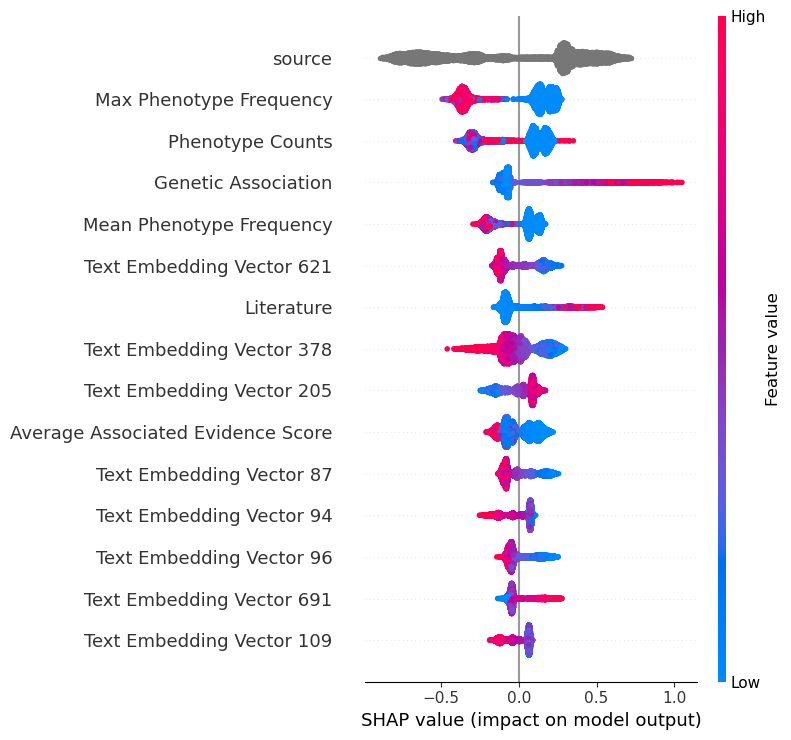

In [49]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X,class_names=model.classes_,max_display=15,show=False)
if SAVE_CANDIDATES:
    plt.savefig('./outputs/Fig-Feature_Importance_All.png',dpi=900, bbox_inches='tight')
plt.show()

#### predicted to have children, but annotated as 0 in DB:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


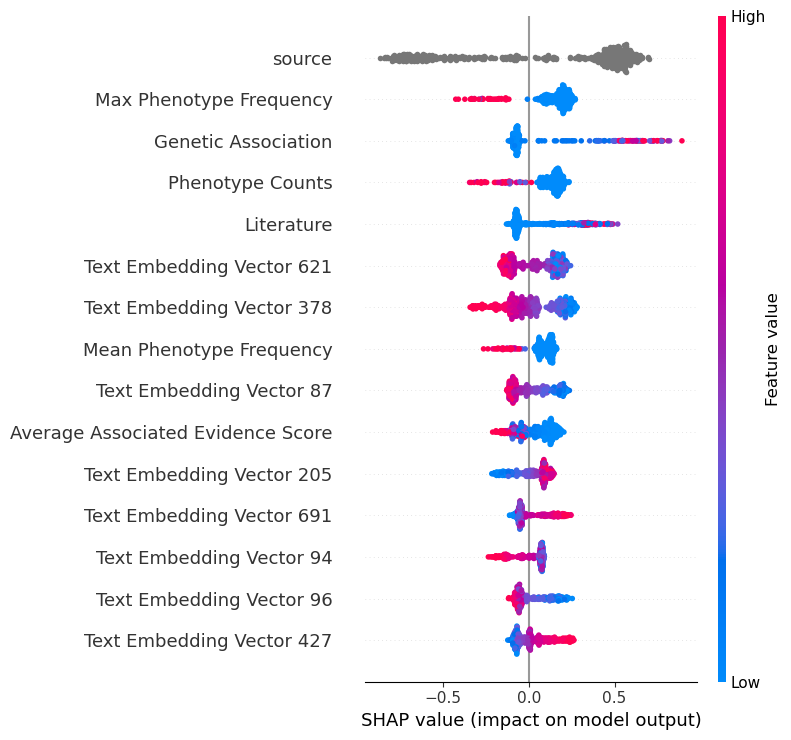

In [50]:
shap_values = explainer.shap_values(X[mask_pred_pos],y[mask_pred_pos])
shap.summary_plot(shap_values, X[mask_pred_pos],max_display=15,show=False)
if SAVE_CANDIDATES:
    plt.savefig('./outputs/Fig-Feature_Importance_positive_candidates.png',dpi=900, bbox_inches='tight')
plt.show()
# fig_shap_positive_candidate = shap.summary_plot(shap_values, X[mask_pred_pos],class_names=model.classes_, show=False)

#### predicted to nothave children, but annotated as 1 in DB:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


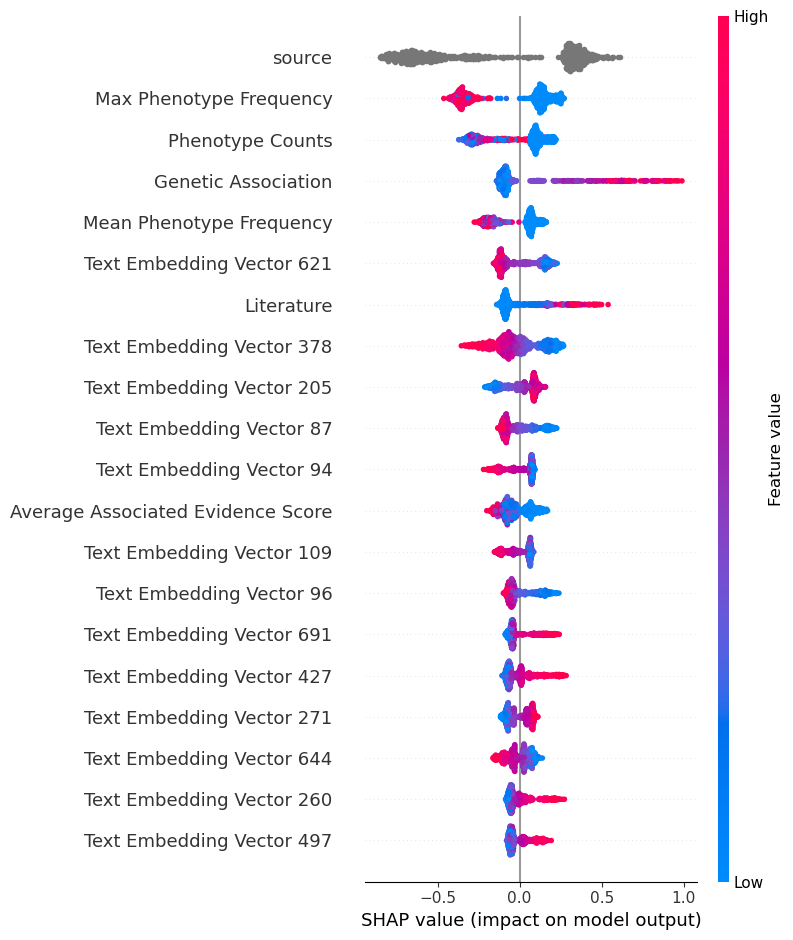

In [51]:
shap_values = explainer.shap_values(X[mask_pred_neg],y[mask_pred_neg])
shap.summary_plot(shap_values, X[mask_pred_neg], show=False)

if SAVE_CANDIDATES:
    plt.savefig('./outputs/Fig-Feature_Importance_negative_candidate.png',dpi=900, bbox_inches='tight')
plt.show()

#### Explain embeddings - In `interprete_embeddings.ipynb`

* Get predictions & By source
    * Copied from main notebook, needs changing to un ok

In [52]:
df["source"].nunique()

12